In [1]:
# Импорт необходимых библиотек
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import nltk
import re
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from sklearn.neighbors import NearestNeighbors
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

# Загрузка необходимых данных для nltk
nltk.download('punkt')

# Текст для обработки
text = """
Машинное обучение продолжает преобразовывать подходы к обработке текстов, предоставляя инструменты для анализа больших объемов данных. Современные алгоритмы, такие как трансформеры, позволяют выявлять глубокие смысловые связи в тексте, делая возможным его использование в различных приложениях.

Технологии обработки естественного языка активно применяются в чат-ботах, системах автоматического перевода и анализе тональности. Например, нейронные сети способны находить скрытые закономерности в текстах, улучшая качество взаимодействия между человеком и машиной.

Тем не менее, создание эффективных моделей требует значительных ресурсов. Обучение глубоких нейронных сетей связано с обработкой больших объемов данных и необходимостью использования мощных вычислительных кластеров для достижения высокой производительности.

Одной из ключевых задач в области текстовой аналитики остается интерпретируемость моделей. Использование внимания в трансформерах не только улучшает точность анализа, но и позволяет понять, какие части текста играют наиболее важную роль при принятии решений.

Интеграция методов обработки текста с другими областями, такими как компьютерное зрение и анализ аудио, открывает путь к созданию мультимодальных систем. Такие подходы используются для генерации контента, автоматической модерации и других задач, требующих обработки сложных данных.

Будущее обработки естественного языка обещает еще более глубокую интеграцию ИИ в повседневную жизнь. Системы станут не просто инструментами, а полноценными интеллектуальными помощниками, способными воспринимать и обрабатывать информацию так же эффективно, как это делает человек.
"""

# Параметр для ограничения контекста по количеству символов в каждом контексте
context_char_limit = 500  # Максимальное количество символов в одном контексте


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Шаг 1: Разбиение текста на абзацы
paragraphs = re.split(r'\n\s*\n', text.strip())

In [3]:
# Шаг 2: Разбиение абзацев на предложения и получение позиций предложений в тексте
sentences = []
sentence_paragraph_mapping = []
sentence_positions = []

current_pos = 0  # Текущая позиция в тексте

for para_idx, paragraph in enumerate(paragraphs):
    para_sentences = nltk.sent_tokenize(paragraph)
    for sent in para_sentences:
        # Найти позицию предложения в тексте
        start_idx = text.find(sent, current_pos)
        end_idx = start_idx + len(sent)
        sentences.append(sent)
        sentence_paragraph_mapping.append(para_idx)
        sentence_positions.append((start_idx, end_idx))
        current_pos = end_idx  # Обновить текущую позицию

In [5]:
# Шаг 3: Вычисление эмбеддингов предложений
model = SentenceTransformer("ai-forever/ru-en-RoSBERTa")
sentence_embeddings = model.encode(sentences)

# Шаг 4: Вычисление матрицы семантического сходства
similarity_matrix = cosine_similarity(sentence_embeddings)

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Шаг 5: Построение графа связности с учетом ограничения по абзацам
G = nx.Graph()

# Добавление узлов в граф
for idx, sentence in enumerate(sentences):
    paragraph_idx = sentence_paragraph_mapping[idx]
    G.add_node(idx, sentence=sentence, paragraph=paragraph_idx)

# Добавление ребер с весами в граф с учетом ближайших абзацев
num_sentences = len(sentences)
for i in range(num_sentences):
    para_i = sentence_paragraph_mapping[i]
    for j in range(i + 1, num_sentences):
        para_j = sentence_paragraph_mapping[j]
        # Проверяем, находятся ли предложения в том же или соседних абзацах
        if abs(para_i - para_j) <= 1:
            similarity = similarity_matrix[i][j]
            # Устанавливаем порог сходства для создания ребра
            if similarity > 0.5:
                G.add_edge(i, j, weight=similarity)

In [7]:
# Шаг 6: Получение связных компонент графа (контекстов)
contexts = []
for component in nx.connected_components(G):
    contexts.append(component)

In [8]:

# Шаг 7: Ограничение контекстов по количеству символов
final_contexts = []
for component in contexts:
    # Получаем список предложений в компоненте
    component_sentences = [sentences[idx] for idx in component]
    # Вычисляем общий размер компоненты в символах
    total_chars = sum(len(sent) for sent in component_sentences)
    if total_chars <= context_char_limit:
        final_contexts.append((component, component_sentences))
    else:
        # Если компонент слишком большой, разбиваем его на меньшие контексты
        sorted_indices = sorted(component, key=lambda x: sentence_positions[x][0])
        temp_context = []
        temp_indices = []
        temp_chars = 0
        for idx in sorted_indices:
            sent = sentences[idx]
            sent_length = len(sent)
            if temp_chars + sent_length <= context_char_limit:
                temp_context.append(sent)
                temp_indices.append(idx)
                temp_chars += sent_length
            else:
                if temp_context:
                    final_contexts.append((set(temp_indices), temp_context))
                temp_context = [sent]
                temp_indices = [idx]
                temp_chars = sent_length
        if temp_context:
            final_contexts.append((set(temp_indices), temp_context))

print(final_contexts)

[({0, 1, 2}, ['Машинное обучение продолжает преобразовывать подходы к обработке текстов, предоставляя инструменты для анализа больших объемов данных.', 'Современные алгоритмы, такие как трансформеры, позволяют выявлять глубокие смысловые связи в тексте, делая возможным его использование в различных приложениях.', 'Технологии обработки естественного языка активно применяются в чат-ботах, системах автоматического перевода и анализе тональности.']), ({3, 4, 5, 6}, ['Например, нейронные сети способны находить скрытые закономерности в текстах, улучшая качество взаимодействия между человеком и машиной.', 'Тем не менее, создание эффективных моделей требует значительных ресурсов.', 'Обучение глубоких нейронных сетей связано с обработкой больших объемов данных и необходимостью использования мощных вычислительных кластеров для достижения высокой производительности.', 'Одной из ключевых задач в области текстовой аналитики остается интерпретируемость моделей.']), ({8, 9, 7}, ['Использование вниман

C:\Users\Sergey\AppData\Local\Temp\ipykernel_4500\2106359504.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = get_cmap('tab20')


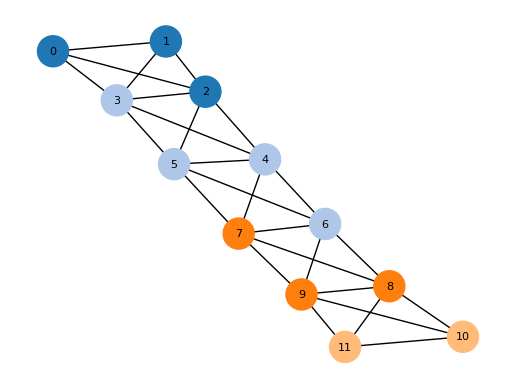

Контексты:

Контекст 1:
- Машинное обучение продолжает преобразовывать подходы к обработке текстов, предоставляя инструменты для анализа больших объемов данных.
- Современные алгоритмы, такие как трансформеры, позволяют выявлять глубокие смысловые связи в тексте, делая возможным его использование в различных приложениях.
- Технологии обработки естественного языка активно применяются в чат-ботах, системах автоматического перевода и анализе тональности.

Контекст 2:
- Например, нейронные сети способны находить скрытые закономерности в текстах, улучшая качество взаимодействия между человеком и машиной.
- Тем не менее, создание эффективных моделей требует значительных ресурсов.
- Обучение глубоких нейронных сетей связано с обработкой больших объемов данных и необходимостью использования мощных вычислительных кластеров для достижения высокой производительности.
- Одной из ключевых задач в области текстовой аналитики остается интерпретируемость моделей.

Контекст 3:
- Использование внимания 

In [9]:
# Шаг 8: Визуализация графа с контекстами
# Создаем цветовую карту для разных контекстов
num_contexts = len(final_contexts)
color_map = get_cmap('tab20')
context_colors = {}

for idx, (component_indices, _) in enumerate(final_contexts):
    color = color_map(idx % 20)
    for node_idx in component_indices:
        context_colors[node_idx] = color

# Позиции узлов для визуализации
pos = nx.spring_layout(G, seed=42)  # Можно использовать другие алгоритмы размещения

# Рисуем узлы
node_colors = [context_colors.get(node, (0.5, 0.5, 0.5)) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)

# Рисуем ребра
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)

# Добавляем подписи к узлам (можно использовать предложения или индексы)
labels = {idx: idx for idx in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.axis('off')
plt.show()

# Вывод контекстов
print("Контексты:")
for idx, (_, context) in enumerate(final_contexts):
    print(f"\nКонтекст {idx + 1}:")
    for sent in context:
        print(f"- {sent}")

In [10]:
# Bonus, дает +30-50% к качеству
# Шаг 9: Обработка контекстов с использованием модели "IlyaGusev/saiga_llama3_8b"

In [11]:


# Подготовка данных для обработки
context_texts = [' '.join(context[1]) for context in final_contexts]

# Инициализация модели и токенизатора
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

MODEL_NAME = "IlyaGusev/saiga_llama3_8b"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

# Функция генерации описания контекста
def generate_context_summary(context_text):
    prompt = f"\nКратко опишите следующий текст:\n{context_text}\nОписание:"
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        add_special_tokens=False
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=70,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_p=0.9,
            top_k=50,
            temperature=1.0,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Извлекаем только сгенерированное описание
    if 'Описание:' in summary:
        summary = summary.split('Описание:')[-1].strip()
    else:
        summary = summary.strip()
    return summary

# Генерация описаний для контекстов
context_summaries = []
for context_text in context_texts:
    summary = generate_context_summary(context_text)
    context_summaries.append(summary)

busted_contexts = []
for i in range(len(context_summaries)):
    print(context_summaries[i]+"\n\n"+final_contexts[i])
    busted_contexts.append(context_summaries[i]+"\n\n"+final_contexts[i])
# Вывод контекстов
print("Контексты:")
for idx, (_, context) in enumerate(busted_contexts):
    print(f"\nКонтекст {idx + 1}:")
    for sent in context:
        print(f"- {sent}")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


TypeError: can only concatenate str (not "tuple") to str